In [11]:
import numpy as np
import pandas as pd
import random as rn
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, \
    confusion_matrix, f1_score, average_precision_score
import matplotlib.pyplot as plt
import sys
import time
from lolviz import *
from score import *
from plot_anomalies import *

## Credit Card Anomaly Detection

In [12]:
credit = pd.read_csv('creditcard.csv')

In [13]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Building Isolation Forest 

#### 1.  Class Isolation Tree

In [14]:
# Follows algo from https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf
def c_length(n):
    if n > 2:
        return 2.0 * (np.log(n - 1) + 0.5772156649) - (2.0 * (n - 1.) / (n * 1.0))
    elif n == 2:
        return 1
    else:
        return 0

In [15]:
class IsolationTree(object):

    def __init__(self, X, depth, height_limit):
        self.depth = depth  # current depth
        self.X = X  # save the data for now
        self.height_limit = height_limit  # height limit
        self.p = None  # splitvalue
        self.q = None
        self.n_dimension = np.arange(np.shape(X)[1], dtype='int')
        self.n_nodes = 0
        self.size = len(X) # n objects
        self.root = self.fit(X, depth, height_limit)

    def fit(self, X: np.ndarray, depth, height_limit, improved=True):
        """
        Given a 2D matrix of observations, create an isolation tree. Set field
        self.root to the root of that tree and return it.

        If you are working on an improved algorithm, check parameter "improved"
        and switch to your new functionality else fall back on your original code.
        """
        self.depth = depth

        if depth >= height_limit or len(X) <= 1:
            left = None
            right = None
            self.n_nodes += 1
            return Node(X, depth, self.p, self.q, left, right, ntype='exNode')

        else:
            self.q = rn.choice(self.n_dimension)
            X_sub = X[:, self.q]
            maximum = np.amax(X_sub)
            minimum = np.amin(X_sub)
            self.p = rn.uniform(minimum, maximum)
            w = np.where(X[:, self.q] < self.p, True, False)

            return Node(X, depth, self.p, self.q,
                        left=self.fit(X[w], depth+1, height_limit),
                        right=self.fit(X[~w], depth + 1, height_limit),
                        ntype='inNode')

    def get_node(self, path):
        node = self.root
        for p in path:
            if p == 'L': node = node.left
            if p == 'R': node = node.right
        return node

#### 2. Isolation Forest

In [16]:
class IsolationTreeEnsemble(object):
    def __init__(self, sample_size, n_trees=10, limit=None):
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.trees = []
        self.limit = limit
        self.c = c_length(sample_size)
        # self.X = X

    def fit(self, X: np.ndarray, improved=True):
        """
        Given a 2D matrix of observations, create an ensemble of IsolationTree
        objects and store them in a list: self.trees.  Convert DataFrames to
        ndarray objects.
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
        lenX = len(X)

        if self.limit is None:
            self.limit = int(np.ceil(np.log2(self.sample_size)))

        for i in range(self.n_trees):
            ind = rn.sample(range(lenX), self.sample_size)
            X_p = X[ind]
            self.trees.append(IsolationTree(X_p, 0, self.limit))

        return self

    def path_length(self, X: np.ndarray) -> np.ndarray:
        """
        Given a 2D matrix of observations, X, compute the average path length
        for each observation in X.  Compute the path length for x_i using every
        tree in self.trees then compute the average for each x_i.  Return an
        ndarray of shape (len(X),1).
        """
        lenX = len(X)
        if isinstance(X, pd.DataFrame):
            X = X.values

        P = np.zeros(lenX)
        for i in range(lenX):
            p_temp = 0
            x = X[i]
            for j in range(self.n_trees):
                T = self.trees[j].root
                while T.ntype != 'exNode':
                    p_temp += 1
                    if x[T.q] < T.p:
                        T = T.left
                    else:
                        T = T.right

                p_temp += c_length(T.size)
            Eh = p_temp / self.n_trees
            P[i] = Eh
        return P

    def anomaly_score(self, X: np.ndarray) -> np.ndarray:
        """
        Given a 2D matrix of observations, X, compute the anomaly score
        for each x_i observation, returning an ndarray of them.
        """

        lenX = len(X)
        if isinstance(X, pd.DataFrame):
            X = X.values

        P = np.zeros(lenX)
        for i in range(lenX):
            p_temp = 0
            x = X[i]
            for j in range(self.n_trees):
                T = self.trees[j].root
                while T.ntype != 'exNode':
                    p_temp += 1
                    if x[T.q] < T.p:
                        T = T.left
                    else:
                        T = T.right

                p_temp += c_length(T.size)

            Eh = p_temp / self.n_trees
            P[i] = 2.0 ** (-Eh / self.c)

        return P

    def predict_from_anomaly_scores(self, scores: np.ndarray, threshold: float) -> np.ndarray:
        """
        Given an array of scores and a score threshold, return an array of
        the predictions: 1 for any score >= the threshold and 0 otherwise.
        """
        R = np.zeros(len(scores))
        for i in range(len(scores)):
            if scores[i] > threshold:
                R[i] = 1
            else:
                R[i] = 0
        return R

    def predict(self, X: np.ndarray, threshold: float) -> np.ndarray:
        "A shorthand for calling anomaly_score() and predict_from_anomaly_scores()."
        score_array = self.anomaly_score(X)

        return self.predict_from_anomaly_scores(score_array, threshold)

#### 3. Node Class

In [17]:
class Node(object):
    def __init__(self, X, depth, p, q, left, right, ntype=''):
        self.depth = depth  # current depth
        self.size = len(X)
        self.q = q  # attribute
        self.p = p  # split value
        self.left = left
        self.right = right
        self.ntype = ntype
        #self.X = X


## Visualizing the results

In [18]:
# sample 
N = 15_000
credit = credit.sample(N)  # grab random subset (too slow otherwise)

X, y = credit.drop('Class', axis=1), credit['Class']

fit time 0.40s
score time 20.47s
Computed 0.8000 TPR threshold 0.6000 with FPR 0.0035
[[14924    52]
 [    4    20]]
Proportion anomalies/normal = 24/14976 = 0.2%
F1 score 0.4167, avg PR 0.4151


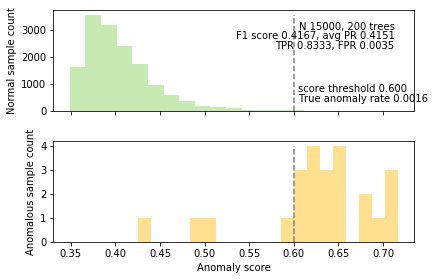

In [19]:
plot_anomalies(X, y, sample_size=256, n_trees = 200, desired_TPR=0.8, percentile = None, normal_ymax=None, bins=20)

In [29]:
it = IsolationTreeEnsemble(sample_size=256,n_trees=200)
isof = it.fit(X)
n_nodes = sum([t.n_nodes for t in it.trees])
print(f'We built {n_nodes} nodes')

We built 8920 nodes


In [25]:
scores = it.anomaly_score(X)

In [26]:
threshold, FPR = find_TPR_threshold(y, scores, 0.8)

In [27]:
y_pred = it.predict_from_anomaly_scores(scores, threshold=threshold)
confusion = confusion_matrix(y, y_pred)
TN, FP, FN, TP = confusion.flat
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

In [28]:
confusion

array([[14781,   195],
       [    3,    21]])

## Tree Visualization using small samples

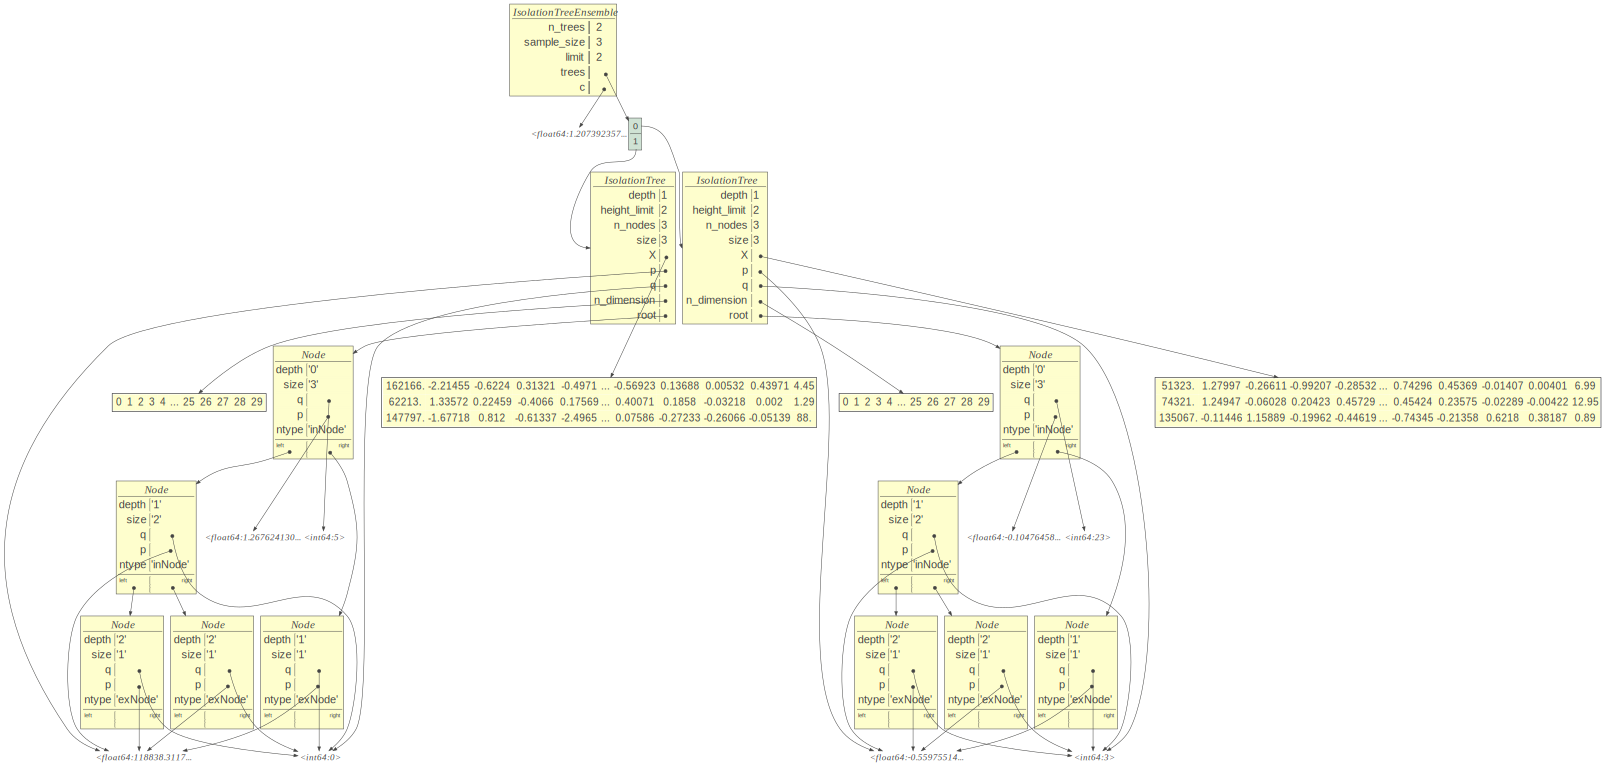

In [32]:
it = IsolationTreeEnsemble(sample_size=3,n_trees=2)
isof = it.fit(X)
treeviz(isof)

### Second Example: http data

In [33]:
http = pd.read_csv('http.csv')
http.head()

,f1,f2,f3,attack
0,-2.302585,5.371103,10.716107,0
1,-2.302585,5.088213,8.418058,0
2,-2.302585,5.464255,7.113224,0
3,-2.302585,5.451468,7.616825,0
4,-2.302585,5.476882,6.186414,0


fit time 0.24s
score time 21.85s
Computed 0.8000 TPR threshold 0.6900 with FPR 0.0001
[[14951     1]
 [    1    47]]
Proportion anomalies/normal = 48/14952 = 0.3%
F1 score 0.9792, avg PR 0.9749


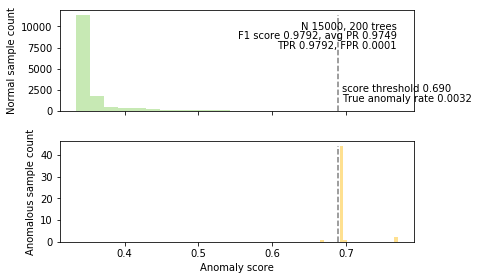

In [34]:
# sample 
N = 15_000
http= http.sample(N)  # grab random subset (too slow otherwise)

X, y = http.drop('attack', axis=1), http['attack']
plot_anomalies(X, y, sample_size=256, n_trees = 200, desired_TPR=0.8, percentile = None, normal_ymax=None, bins=20)

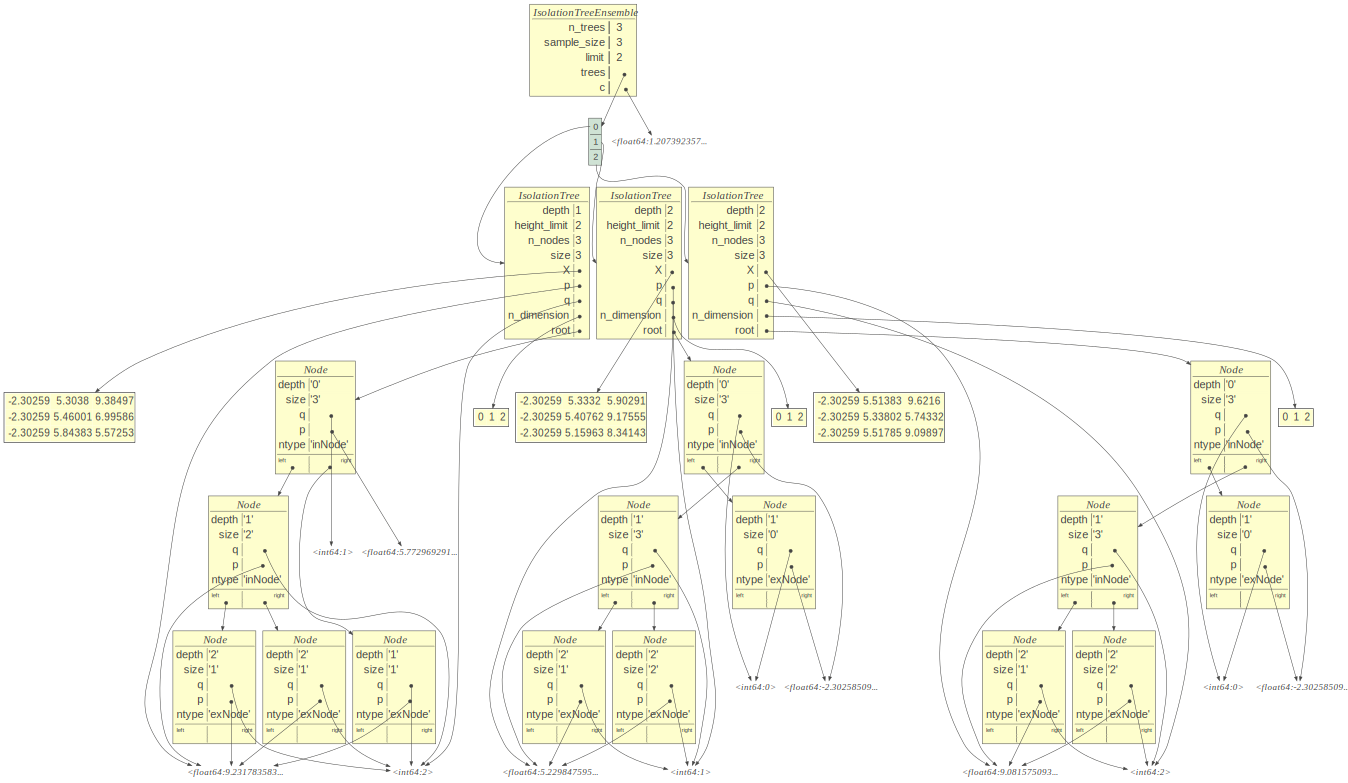

In [35]:
it = IsolationTreeEnsemble(sample_size=3,n_trees=3)
isof = it.fit(X)
treeviz(isof)